Porter Stemmer

In [1]:
import sys

class PorterStemmer:

    def __init__(self):
        """The main part of the stemming algorithm starts here.
        b is a buffer holding a word to be stemmed. The letters are in b[k0],
        b[k0+1] ... ending at b[k]. In fact k0 = 0 in this demo program. k is
        readjusted downwards as the stemming progresses. Zero termination is
        not in fact used in the algorithm.

        Note that only lower case sequences are stemmed. Forcing to lower case
        should be done before stem(...) is called.
        """

        self.b = ""  # buffer for word to be stemmed
        self.k = 0
        self.k0 = 0
        self.j = 0   # j is a general offset into the string

    def cons(self, i):
        """cons(i) is TRUE <=> b[i] is a consonant."""
        if self.b[i] == 'a' or self.b[i] == 'e' or self.b[i] == 'i' or self.b[i] == 'o' or self.b[i] == 'u':
            return 0
        if self.b[i] == 'y':
            if i == self.k0:
                return 1
            else:
                return (not self.cons(i - 1))
        return 1

    def m(self):
        """m() measures the number of consonant sequences between k0 and j.
        if c is a consonant sequence and v a vowel sequence, and <..>
        indicates arbitrary presence,

           <c><v>       gives 0
           <c>vc<v>     gives 1
           <c>vcvc<v>   gives 2
           <c>vcvcvc<v> gives 3
           ....
        """
        n = 0
        i = self.k0
        while 1:
            if i > self.j:
                return n
            if not self.cons(i):
                break
            i = i + 1
        i = i + 1
        while 1:
            while 1:
                if i > self.j:
                    return n
                if self.cons(i):
                    break
                i = i + 1
            i = i + 1
            n = n + 1
            while 1:
                if i > self.j:
                    return n
                if not self.cons(i):
                    break
                i = i + 1
            i = i + 1

    def vowelinstem(self):
        """vowelinstem() is TRUE <=> k0,...j contains a vowel"""
        for i in range(self.k0, self.j + 1):
            if not self.cons(i):
                return 1
        return 0

    def doublec(self, j):
        """doublec(j) is TRUE <=> j,(j-1) contain a double consonant."""
        if j < (self.k0 + 1):
            return 0
        if (self.b[j] != self.b[j-1]):
            return 0
        return self.cons(j)

    def cvc(self, i):
        """cvc(i) is TRUE <=> i-2,i-1,i has the form consonant - vowel - consonant
        and also if the second c is not w,x or y. this is used when trying to
        restore an e at the end of a short  e.g.

           cav(e), lov(e), hop(e), crim(e), but
           snow, box, tray.
        """
        if i < (self.k0 + 2) or not self.cons(i) or self.cons(i-1) or not self.cons(i-2):
            return 0
        ch = self.b[i]
        if ch == 'w' or ch == 'x' or ch == 'y':
            return 0
        return 1

    def ends(self, s):
        """ends(s) is TRUE <=> k0,...k ends with the string s."""
        length = len(s)
        if s[length - 1] != self.b[self.k]: # tiny speed-up
            return 0
        if length > (self.k - self.k0 + 1):
            return 0
        if self.b[self.k-length+1:self.k+1] != s:
            return 0
        self.j = self.k - length
        return 1

    def setto(self, s):
        """setto(s) sets (j+1),...k to the characters in the string s, readjusting k."""
        length = len(s)
        self.b = self.b[:self.j+1] + s + self.b[self.j+length+1:]
        self.k = self.j + length

    def r(self, s):
        """r(s) is used further down."""
        if self.m() > 0:
            self.setto(s)

    def step1ab(self):
        """step1ab() gets rid of plurals and -ed or -ing. e.g.

           caresses  ->  caress
           ponies    ->  poni
           ties      ->  ti
           caress    ->  caress
           cats      ->  cat

           feed      ->  feed
           agreed    ->  agree
           disabled  ->  disable

           matting   ->  mat
           mating    ->  mate
           meeting   ->  meet
           milling   ->  mill
           messing   ->  mess

           meetings  ->  meet
        """
        if self.b[self.k] == 's':
            if self.ends("sses"):
                self.k = self.k - 2
            elif self.ends("ies"):
                self.setto("i")
            elif self.b[self.k - 1] != 's':
                self.k = self.k - 1
        if self.ends("eed"):
            if self.m() > 0:
                self.k = self.k - 1
        elif (self.ends("ed") or self.ends("ing")) and self.vowelinstem():
            self.k = self.j
            if self.ends("at"):   self.setto("ate")
            elif self.ends("bl"): self.setto("ble")
            elif self.ends("iz"): self.setto("ize")
            elif self.doublec(self.k):
                self.k = self.k - 1
                ch = self.b[self.k]
                if ch == 'l' or ch == 's' or ch == 'z':
                    self.k = self.k + 1
            elif (self.m() == 1 and self.cvc(self.k)):
                self.setto("e")

    def step1c(self):
        """step1c() turns terminal y to i when there is another vowel in the stem."""
        if (self.ends("y") and self.vowelinstem()):
            self.b = self.b[:self.k] + 'i' + self.b[self.k+1:]

    def step2(self):
        """step2() maps double suffices to single ones.
        so -ization ( = -ize plus -ation) maps to -ize etc. note that the
        string before the suffix must give m() > 0.
        """
        if self.b[self.k - 1] == 'a':
            if self.ends("ational"):   self.r("ate")
            elif self.ends("tional"):  self.r("tion")
        elif self.b[self.k - 1] == 'c':
            if self.ends("enci"):      self.r("ence")
            elif self.ends("anci"):    self.r("ance")
        elif self.b[self.k - 1] == 'e':
            if self.ends("izer"):      self.r("ize")
        elif self.b[self.k - 1] == 'l':
            if self.ends("bli"):       self.r("ble") # --DEPARTURE--
            # To match the published algorithm, replace this phrase with
            #   if self.ends("abli"):      self.r("able")
            elif self.ends("alli"):    self.r("al")
            elif self.ends("entli"):   self.r("ent")
            elif self.ends("eli"):     self.r("e")
            elif self.ends("ousli"):   self.r("ous")
        elif self.b[self.k - 1] == 'o':
            if self.ends("ization"):   self.r("ize")
            elif self.ends("ation"):   self.r("ate")
            elif self.ends("ator"):    self.r("ate")
        elif self.b[self.k - 1] == 's':
            if self.ends("alism"):     self.r("al")
            elif self.ends("iveness"): self.r("ive")
            elif self.ends("fulness"): self.r("ful")
            elif self.ends("ousness"): self.r("ous")
        elif self.b[self.k - 1] == 't':
            if self.ends("aliti"):     self.r("al")
            elif self.ends("iviti"):   self.r("ive")
            elif self.ends("biliti"):  self.r("ble")
        elif self.b[self.k - 1] == 'g': # --DEPARTURE--
            if self.ends("logi"):      self.r("log")
        # To match the published algorithm, delete this phrase

    def step3(self):
        """step3() dels with -ic-, -full, -ness etc. similar strategy to step2."""
        if self.b[self.k] == 'e':
            if self.ends("icate"):     self.r("ic")
            elif self.ends("ative"):   self.r("")
            elif self.ends("alize"):   self.r("al")
        elif self.b[self.k] == 'i':
            if self.ends("iciti"):     self.r("ic")
        elif self.b[self.k] == 'l':
            if self.ends("ical"):      self.r("ic")
            elif self.ends("ful"):     self.r("")
        elif self.b[self.k] == 's':
            if self.ends("ness"):      self.r("")

    def step4(self):
        """step4() takes off -ant, -ence etc., in context <c>vcvc<v>."""
        if self.b[self.k - 1] == 'a':
            if self.ends("al"): pass
            else: return
        elif self.b[self.k - 1] == 'c':
            if self.ends("ance"): pass
            elif self.ends("ence"): pass
            else: return
        elif self.b[self.k - 1] == 'e':
            if self.ends("er"): pass
            else: return
        elif self.b[self.k - 1] == 'i':
            if self.ends("ic"): pass
            else: return
        elif self.b[self.k - 1] == 'l':
            if self.ends("able"): pass
            elif self.ends("ible"): pass
            else: return
        elif self.b[self.k - 1] == 'n':
            if self.ends("ant"): pass
            elif self.ends("ement"): pass
            elif self.ends("ment"): pass
            elif self.ends("ent"): pass
            else: return
        elif self.b[self.k - 1] == 'o':
            if self.ends("ion") and (self.b[self.j] == 's' or self.b[self.j] == 't'): pass
            elif self.ends("ou"): pass
            # takes care of -ous
            else: return
        elif self.b[self.k - 1] == 's':
            if self.ends("ism"): pass
            else: return
        elif self.b[self.k - 1] == 't':
            if self.ends("ate"): pass
            elif self.ends("iti"): pass
            else: return
        elif self.b[self.k - 1] == 'u':
            if self.ends("ous"): pass
            else: return
        elif self.b[self.k - 1] == 'v':
            if self.ends("ive"): pass
            else: return
        elif self.b[self.k - 1] == 'z':
            if self.ends("ize"): pass
            else: return
        else:
            return
        if self.m() > 1:
            self.k = self.j

    def step5(self):
        """step5() removes a final -e if m() > 1, and changes -ll to -l if
        m() > 1.
        """
        self.j = self.k
        if self.b[self.k] == 'e':
            a = self.m()
            if a > 1 or (a == 1 and not self.cvc(self.k-1)):
                self.k = self.k - 1
        if self.b[self.k] == 'l' and self.doublec(self.k) and self.m() > 1:
            self.k = self.k -1

    def stem(self, p, i, j):
        """In stem(p,i,j), p is a char pointer, and the string to be stemmed
        is from p[i] to p[j] inclusive. Typically i is zero and j is the
        offset to the last character of a string, (p[j+1] == '\0'). The
        stemmer adjusts the characters p[i] ... p[j] and returns the new
        end-point of the string, k. Stemming never increases word length, so
        i <= k <= j. To turn the stemmer into a module, declare 'stem' as
        extern, and delete the remainder of this file.
        """
        # copy the parameters into statics
        self.b = p
        self.k = j
        self.k0 = i
        if self.k <= self.k0 + 1:
            return self.b # --DEPARTURE--

        # With this line, strings of length 1 or 2 don't go through the
        # stemming process, although no mention is made of this in the
        # published algorithm. Remove the line to match the published
        # algorithm.

        self.step1ab()
        self.step1c()
        self.step2()
        self.step3()
        self.step4()
        self.step5()
        return self.b[self.k0:self.k+1]


In [17]:
from collections import Counter
import csv
import os
import math
import sys
import json
import nltk
import re
import numpy as np
stopwords = ['a', 'an', 'the', 'them', 'is', 'are', 'am', 'i', 'he', 'she', 'it', 'they']

def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    ret = ""
    for i in range(0, len(data)):
    	if data[i] in symbols:
    		ret+=' '
    	else:
    		ret += data[i] 
    return ret

def stemming(line, stopwords):
	p = PorterStemmer()
	output = []
	for c in line:
		if c == '' or c in stopwords:
			continue
		word = c.strip()
		if word.isalpha():
			word = word.lower()
		stemmed = p.stem(word, 0, len(word)-1)
		stemmed = stemmed.strip()
		if stemmed in stopwords or len(stemmed) < 3:
			continue
		if stemmed != '':
			output.append(stemmed)
		word = ''
	return output

def getQueries(filename):
	file = open(filename, 'r')
	queries = []
	while(True):
		str = file.readline()
		if(str == ""):
			break
		prev = 'A'
		curr = 'A'
		i = 0
		while(True):
			prev = curr
			curr = str[i]
			if(prev == '|' and curr == '|'):
				break
			i+=1
		#pre-processing
		text = remove_punctuation(str[i+1:])
		words = tokenization(text)
		stemmed = stemming(words, stopwords)
		queries.append(stemmed)
	file.close()
	return queries

def tokenization(line):
	return re.split(r'[,.:;"`\'\(\)\{\}\[\] ]+|\n', line)
    
def getWords(doc, type):
	if(type == 'p'):
		file = open('./drive/MyDrive/AILA_2019_dataset/Object_casedocs/'+doc, 'r')
		text = file.read()
		text = remove_punctuation(text)
		words = tokenization(text)
		return stemming(words, stopwords)
	else:
		file = open('./drive/MyDrive/AILA_2019_dataset/Object_statutes/'+doc, 'r')
		text = file.read()
		text = remove_punctuation(text)
		words = tokenization(text)
		return stemming(words, stopwords)

def getDictionary(text):
	dic = {}
	for word in text:
		if word in dic:
			dic[word] += 1
		else:
			dic[word] = 1
	return dic

def getTfIdf(allwords, text, lenDocs):
	cnt = getDictionary(text)
	tf = {}
	for word in cnt:
		tf[word] = cnt[word]/len(text)
	idf = {}
	for word in cnt:
		if word in allwords:
			idf[word] = math.log(lenDocs/allwords[word])
		else:
			idf[word] = 0
	tfIdf = {}
	for word in tf:
		tfIdf[word] = tf[word]*idf[word]
	return tfIdf

def getBM25(cntDoc, query, avgDlen, lenDoc, totalDocs, allwords):
	cnt = Counter(query)
	fqD = {}
	for word in cnt:
		fqD[word] = cntDoc[word]/lenDoc
	modD = lenDoc
	k = 1.25
	b = 0.75
	tf = {}
	for word in cnt:
		tf[word] = (fqD[word]*(k+1))/(fqD[word]+k*(1-b+b*(lenDoc/avgDlen)))

	idf = {}
	for word in cnt:
		nq = 0
		if word in allwords:
			nq = allwords[word]
		idf[word] = math.log(((totalDocs-nq+0.5)/(nq+0.5))+1)

	sum = 0
	for word in tf:
		sum += tf[word]*idf[word]
	return sum

In [33]:
queryList = getQueries('./drive/MyDrive/AILA_2019_dataset/Query_doc.txt')
totalQueries = len(queryList)
print("step 1 complete")

#reading relevant and non-relevant documents of the queries
file = open('./drive/MyDrive/AILA_2019_dataset/relevance_judgments_priorcases.txt', 'r')
queryRel = []
queryNonRel = []
for i in range(0, totalQueries):
	queryRel.append([])
	queryNonRel.append([])

#filling queryRel and queryNonRel
while(True):
	str1 = file.readline()
	if(str1 == ''):
		break
	str1 = str1.split()
	if(int(str1[3]) == 0):
		queryNonRel[int(str1[0][6:])-1].append(str1[2])
	else:
		queryRel[int(str1[0][6:])-1].append(str1[2])
file.close()
print("step 2 complete")


#reading relevant and non-relevant documents of the queries
file = open('./drive/MyDrive/AILA_2019_dataset/relevance_judgments_statutes.txt', 'r')
queryRelS = []
queryNonRelS = []
for i in range(0, totalQueries):
	queryRelS.append([])
	queryNonRelS.append([])

#filling queryRel and queryNonRel
while(True):
	str1 = file.readline()
	if(str1 == ''):
		break
	str1 = str1.split()
	if(int(str1[3]) == 0):
		queryNonRelS[int(str1[0][6:])-1].append(str1[2])
	else:
		queryRelS[int(str1[0][6:])-1].append(str1[2])
file.close()
print("step 3 complete")

step 1 complete
step 2 complete
step 3 complete


In [21]:
graphRanksCase = []
graphRanksStatutes = []
for i in range(0, 10):
  graphRanksCase.append(0)
for i in range(0, 20):
  graphRanksStatutes.append(0)

For prior Cases

In [23]:
# reading all casedocs and creating dictionary of words
# docs: ['C1.txt', 'C2.txt', .......]
# allwords: dictionary with key : word and value : no. of docs in which the word appears
# total: dictionary with key : doc_name and value : total no. of words in that document
# tfDocuments : dictionary with key : doc_name and value : a dictionary with (key : word, value : frequency of the word in that document)

docs = os.listdir("./drive/MyDrive/AILA_2019_dataset/Object_casedocs")
allwords = {}
avgDlen = 0
tfDocuments = {}
total = {}
for doc in docs:
	content = getWords(doc, 'p')
	avgDlen += len(content)
	cnt = Counter(content)
	total[doc] = len(content)
	tfDocuments[doc] = cnt
	for word in cnt:
		if word not in allwords:
			allwords[word]=1
		else:
			allwords[word]+=1
print("step 3 complete")

avgDlen = avgDlen/len(docs)

# idf : dictionary with key : word and value : idf value of that word
idf = {}
for word in allwords:
	idf[word] = math.log(len(docs)/allwords[word])


# tfIdfDocs : dictionary with key: doc_name, value : tfIdf value dictionary (word, float) of that document
tfIdfDocs = {}
for doc in docs:
	cnt = tfDocuments[doc]
	tf = {}
	for word in cnt:
		tf[word] = cnt[word]/total[doc]
	tfIdf = {}
	for word in tf:
		tfIdf[word] = tf[word]*idf[word]
	tfIdfDocs[doc] = tfIdf

print("step 4 complete")
#got tfIdf of each document in vector form
#find tfIdf of queries
tfIdfQueries = {}
for i in range(0, len(queryList)):
	tfIdfQueries[i] = getTfIdf(allwords, queryList[i], len(docs))

print("step 5 complete")
for i in range(0, len(queryList)):
	getResult = {}
	for doc in docs:
		getResult[doc] = getBM25(tfDocuments[doc], queryList[i], avgDlen, len(docs), len(docs), allwords)
	l = []
	for doc in getResult:
		l.append((getResult[doc], doc))
	l.sort(key = lambda x: x[0])
	print("FOR query : "+str(i+1))
	print("Top five retrieved documents: ")
	for j in range(0, 5):
		string = l[len(l)-1-j][1]+" "+str(j+1)+" "+str(l[len(l)-1-j][0])
		print(string)
	print("Ranks of given relevant documents: ")
	for doc in queryRel[i]:
		for j in range(0, len(l)):
			if(l[len(l)-1-j][1] == doc+".txt"):
				print(doc+" "+str(j+1))
				rank = j+1
				if(rank < 1000 and rank >= 0):
					graphRanksCase[rank//100]+=1
				break
print("final finished")


step 3 complete
step 4 complete
step 5 complete
FOR query : 1
Top five retrieved documents: 
C1714.txt 1 1.481838218675648
C1751.txt 2 1.4296376902235144
C855.txt 3 1.3226030654588403
C14.txt 4 1.284566848938926
C1149.txt 5 1.0599726117069228
Ranks of given relevant documents: 
C14 4
C9 1759
FOR query : 2
Top five retrieved documents: 
C169.txt 1 0.7771707181186354
C1777.txt 2 0.6157217342131455
C1149.txt 3 0.5531688922863578
C1512.txt 4 0.5446176505144822
C1853.txt 5 0.5340146037184296
Ranks of given relevant documents: 
C27 1108
C22 460
FOR query : 3
Top five retrieved documents: 
C101.txt 1 0.514239430960861
C1714.txt 2 0.4936281643351323
C14.txt 3 0.3321315949848304
C1751.txt 4 0.3151962385529057
C1777.txt 5 0.3119288457067986
Ranks of given relevant documents: 
C1 1658
FOR query : 4
Top five retrieved documents: 
C169.txt 1 0.9772585915950784
C1777.txt 2 0.6333662727606038
C384.txt 3 0.5499803103370813
C1774.txt 4 0.494988962655019
C2020.txt 5 0.4880000741366941
Ranks of given rel

For statutes

In [35]:
# reading all casedocs and creating dictionary of words
# docs: ['C1.txt', 'C2.txt', .......]
# allwords: dictionary with key : word and value : no. of docs in which the word appears
# total: dictionary with key : doc_name and value : total no. of words in that document
# tfDocuments : dictionary with key : doc_name and value : a dictionary with (key : word, value : frequency of the word in that document)

docs = os.listdir("./drive/MyDrive/AILA_2019_dataset/Object_statutes")
allwords = {}
avgDlen = 0
tfDocuments = {}
total = {}
for doc in docs:
	content = getWords(doc, 's')
	avgDlen += len(content)
	cnt = Counter(content)
	total[doc] = len(content)
	tfDocuments[doc] = cnt
	for word in cnt:
		if word not in allwords:
			allwords[word]=1
		else:
			allwords[word]+=1
print("step 3 complete")

avgDlen = avgDlen/len(docs)

# idf : dictionary with key : word and value : idf value of that word
idf = {}
for word in allwords:
	idf[word] = math.log(len(docs)/allwords[word])


# tfIdfDocs : dictionary with key: doc_name, value : tfIdf value dictionary (word, float) of that document
tfIdfDocs = {}
for doc in docs:
	cnt = tfDocuments[doc]
	tf = {}
	for word in cnt:
		tf[word] = cnt[word]/total[doc]
	tfIdf = {}
	for word in tf:
		tfIdf[word] = tf[word]*idf[word]
	tfIdfDocs[doc] = tfIdf

print("step 4 complete")
#got tfIdf of each document in vector form
#find tfIdf of queries
tfIdfQueries = {}
for i in range(0, len(queryList)):
	tfIdfQueries[i] = getTfIdf(allwords, queryList[i], len(docs))

print("step 5 complete")
for i in range(0, len(queryList)):
	getResult = {}
	for doc in docs:
		getResult[doc] = getBM25(tfDocuments[doc], queryList[i], avgDlen, len(docs), len(docs), allwords)
	l = []
	for doc in getResult:
		l.append((getResult[doc], doc))
	l.sort(key = lambda x: x[0])
	print("FOR query : "+str(i+1))
	print("Top five retrieved documents: ")
	for j in range(0, 5):
		string = l[len(l)-1-j][1]+" "+str(j+1)+" "+str(l[len(l)-1-j][0])
		print(string)
	print("Ranks of given relevant documents: ")
	for doc in queryRelS[i]:
		for j in range(0, len(l)):
			if(l[len(l)-1-j][1] == doc+".txt"):
				print(doc+" "+str(j+1))
				rank = j+1
				if(rank < 1000 and rank >= 0):
					graphRanksStatutes[rank//10]+=1
				break
print("final finished")


step 3 complete
step 4 complete
step 5 complete
FOR query : 1
Top five retrieved documents: 
S67.txt 1 12.472542931883801
S82.txt 2 10.053446349921591
S42.txt 3 7.032535532227068
S87.txt 4 6.548099006817291
S57.txt 5 6.459788075159878
Ranks of given relevant documents: 
S52 116
S3 184
S10 51
S62 84
FOR query : 2
Top five retrieved documents: 
S67.txt 1 5.977738936448425
S82.txt 2 5.475831593684229
S57.txt 3 4.337704263500667
S87.txt 4 4.068356160579149
S170.txt 5 3.26992010732331
Ranks of given relevant documents: 
S127 167
S27 34
FOR query : 3
Top five retrieved documents: 
S82.txt 1 4.244657635990048
S57.txt 2 3.5712124545066333
S134.txt 3 2.95734176529539
S67.txt 4 2.8052929138608302
S87.txt 5 2.5970453900267065
Ranks of given relevant documents: 
S134 3
S33 55
S184 29
S23 132
FOR query : 4
Top five retrieved documents: 
S57.txt 1 5.07602027018201
S170.txt 2 4.818630125155755
S67.txt 3 4.720903015101994
S82.txt 4 4.446163431571589
S87.txt 5 4.190892998952019
Ranks of given relevant 

Graph for prior cases

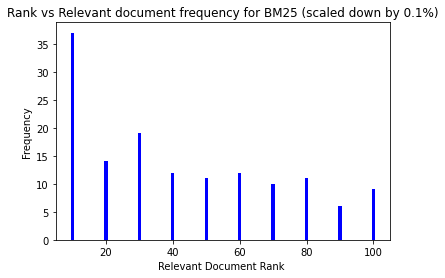

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

data = []
data.append(graphRanksCase)
# data.append(counter9)
# data.append(counter10)

X = np.arange(10,110,10)
plt.bar(X+0, data[0], color = 'b', width = 1)
# plt.bar(X+1.25, data[1], color = 'r', width = 1)
# plt.bar(X+2.50, data[2], color = 'g', width = 1)
plt.xlabel("Relevant Document Rank ")
plt.ylabel("Frequency")
plt.title("Rank vs Relevant document frequency for BM25 (scaled down by 0.1%)")
plt.show()

For statutes

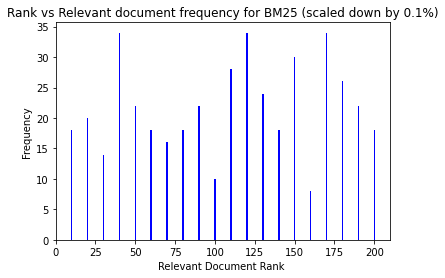

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

data = []
data.append(graphRanksStatutes)
# data.append(counter9)
# data.append(counter10)

X = np.arange(10,210,10)
plt.bar(X+0, data[0], color = 'b', width = 1)
# plt.bar(X+1.25, data[1], color = 'r', width = 1)
# plt.bar(X+2.50, data[2], color = 'g', width = 1)
plt.xlabel("Relevant Document Rank ")
plt.ylabel("Frequency")
plt.title("Rank vs Relevant document frequency for BM25 (scaled down by 0.1%)")
plt.show()